# Challenge: make your own regression model
Now that you've spent some time playing with a sample multivariate linear regression model, it's time to make your own.

You've already gotten started by prepping the FBI:UCR Crime dataset (Thinkful mirror) in a previous assignment.

Using this data, build a regression model to __predict property crimes__. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('~/thinkful_mac/thinkful_large_files/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv', skiprows=4)

In [83]:
# Get a sense of the data quality to figure out if we need to do any cleaning
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [84]:
for col in df.columns:
    print('Column \'{}\' has {} NaN values, representing {}% of the data.'.format(col, np.sum(df[col].isna()), format(100*np.sum(df[col].isna())/len(df), '0.2f')))

Column 'City' has 0 NaN values, representing 0.00% of the data.
Column 'Population' has 3 NaN values, representing 0.85% of the data.
Column 'Violent
crime' has 3 NaN values, representing 0.85% of the data.
Column 'Murder and
nonnegligent
manslaughter' has 3 NaN values, representing 0.85% of the data.
Column 'Rape
(revised
definition)1' has 351 NaN values, representing 100.00% of the data.
Column 'Rape
(legacy
definition)2' has 3 NaN values, representing 0.85% of the data.
Column 'Robbery' has 3 NaN values, representing 0.85% of the data.
Column 'Aggravated
assault' has 3 NaN values, representing 0.85% of the data.
Column 'Property
crime' has 3 NaN values, representing 0.85% of the data.
Column 'Burglary' has 3 NaN values, representing 0.85% of the data.
Column 'Larceny-
theft' has 3 NaN values, representing 0.85% of the data.
Column 'Motor
vehicle
theft' has 3 NaN values, representing 0.85% of the data.
Column 'Arson3' has 164 NaN values, representing 46.72% of the data.


In [85]:
#df.select_dtypes(include=np.number)

# A lot of the data is not numeric in the current form; we should clean it and make the data type float
# We also need to remove commas from the table in order to do this

# Convert everything after 'City' in the feature list to an int
num_col = df.columns[1:].tolist()
for col in num_col:
    df[col] = df[col].apply(lambda x: str(x).replace(',', ''))
    df[col] = df[col].apply(lambda x: float(x))

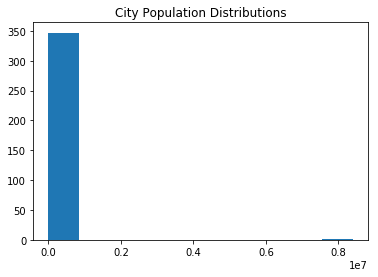

In [86]:
# Let's have a look at our population distribution
plt.hist(df['Population'].dropna())
plt.title('City Population Distributions')
plt.show()

# Outliers
Our data has an extreme outlier, since our population (and other) distribution charts have only two buckets with any values, one of which is the outlier city. Let's find that city and remove it (or perhaps scale it down in some way) so we can get a look at our other dataset properties.

In [87]:
outlier = df['Population'].max()
df[df['Population']==outlier]

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
216,New York,8396126.0,52384.0,335.0,NaN,1112.0,19170.0,31767.0,141971.0,16606.0,117931.0,7434.0,NaN


Unsurprisingly, New York City is the outlier which is causing our population distribution chart to look strange. Let's just scale NYC values down by a factor of 100 so that it blends in with the rest of our data.

In [88]:
for col in num_col:
    df.loc[df['City']=='New York', col] = df.loc[df['City']=='New York', col]/100
df[df['City']=='New York']

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
216,New York,83961.26,523.84,3.35,NaN,11.12,191.7,317.67,1419.71,166.06,1179.31,74.34,NaN


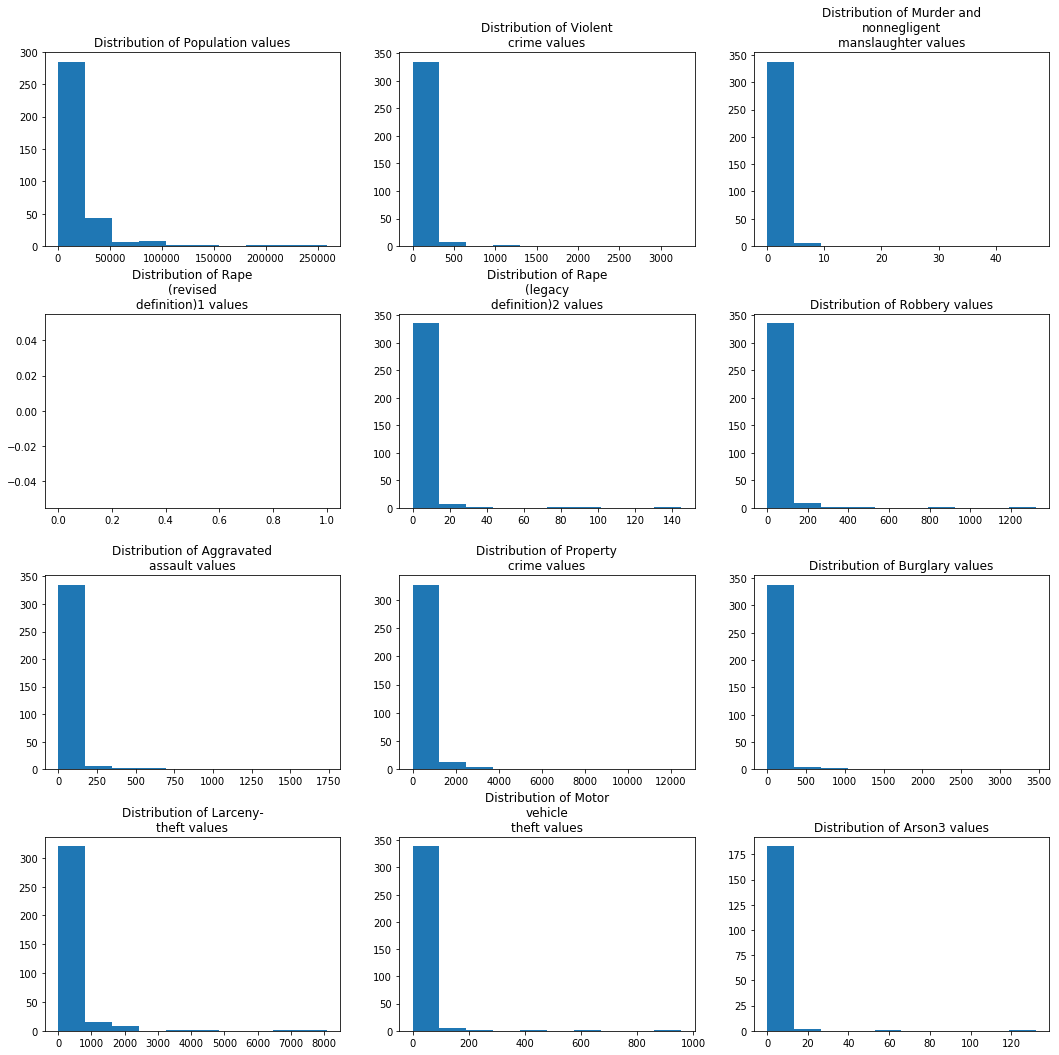

In [89]:
# Now that New York has been scaled down, let's plot the distributions for the features
import math
x = math.ceil(len(num_col)/3)

# Plot 3 charts per row
plt.figure(figsize = (18,18))

#Plot subplots
for i in range(0,len(num_col)):
    plt.subplot(x, 3, i+1)
    plt.hist(df[num_col[i]].dropna())
    plt.title('Distribution of {} values'.format(num_col[i]))

plt.subplots_adjust(hspace=0.35)
plt.show()

Well, after removing the extreme outlier we still see a fair number of outliers remaining which leads to a similar effect in the chart (extreme skew). Let's take a look at how the box-plots look.

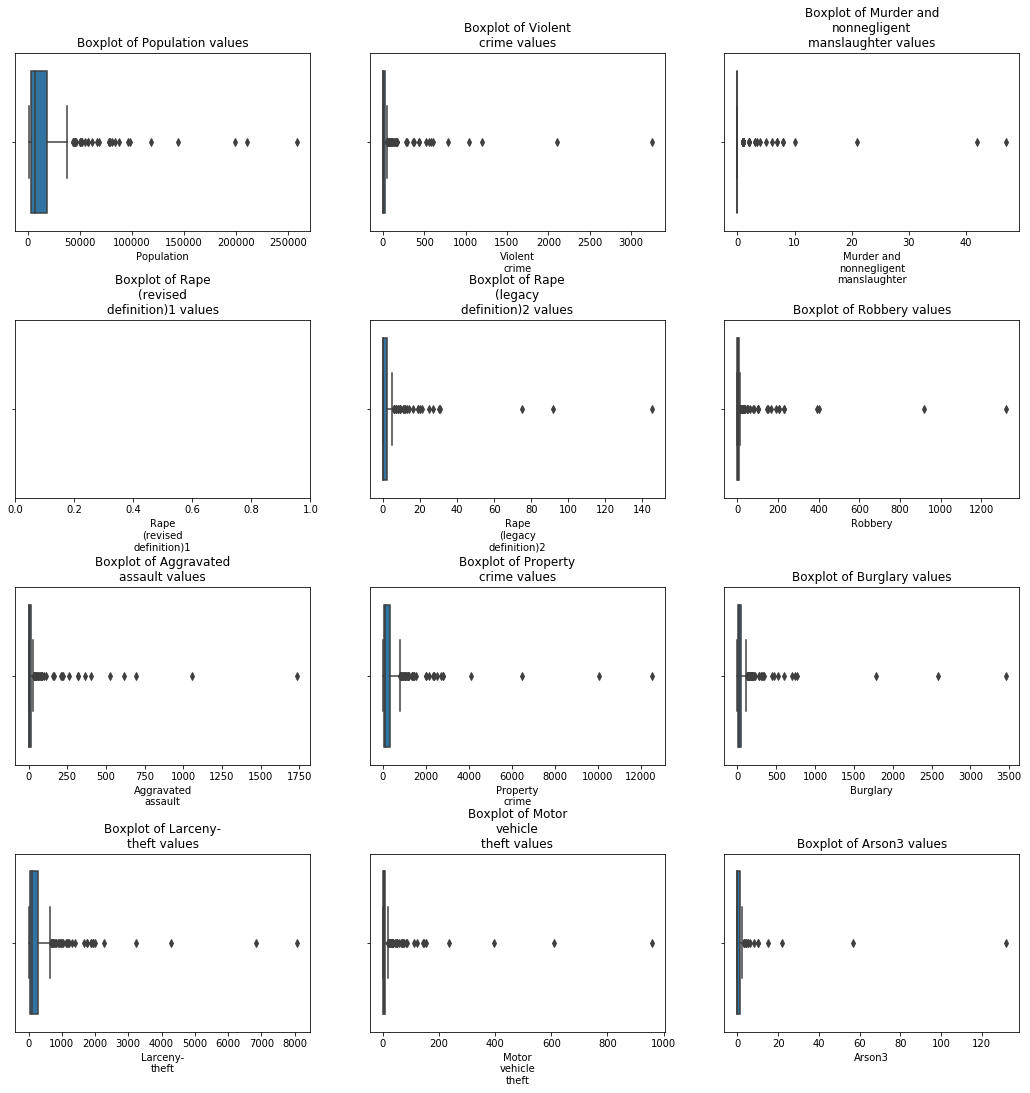

In [90]:
# Now that New York has been scaled down, let's plot the distributions for the features
import math
x = math.ceil(len(num_col)/3)

# Plot 3 charts per row
plt.figure(figsize = (18,18))

#Plot subplots
for i in range(0,len(num_col)):
    plt.subplot(x, 3, i+1)
    sns.boxplot(df[num_col[i]].dropna())
    plt.title('Boxplot of {} values'.format(num_col[i]))

plt.subplots_adjust(hspace=0.5)
plt.show()

Yeah, the outliers are quite evident and numerous. Unfortunately I can't think of a great way to deal with them without simply dropping them in a 'Winsorizing' type approach (delete top and bottom 2.5%). But I think our most densely populated cities contain valuable information and dropping them might bias our results. For now, let's move forward as is.

Now let's add in our variables for Murder and Robbery, as well as Population^2.

In [91]:
# Replace any NaNs with 0
df.fillna(0, inplace=True)

df_final = pd.DataFrame()
df_final['City'] = df.City
df_final['Population'] = df.Population
df_final['Population_Sq'] = df.Population**2
df_final['Murder_Binary'] = df['Murder and\nnonnegligent\nmanslaughter'].apply(lambda x: 1 if x > 0 else 0)
df_final['Robbery_Binary'] = df['Robbery'].apply(lambda x: 1 if x > 0 else 0)
df_final.head()

,City,Population,Population_Sq,Murder_Binary,Robbery_Binary
0,Adams Village,1861.0,3.463321e+06,0,0
1,Addison Town and Village,2577.0,6.640929e+06,0,0
2,Akron Village,2846.0,8.099716e+06,0,0
3,Albany,97956.0,9.595378e+09,1,1
4,Albion Village,6388.0,4.080654e+07,0,1


Let's add back in some of the original features from the dataset that might be predictive, as well as our target variable: property crime.

In [92]:
df_final['Robbery'] = df['Robbery']
df_final['Murder'] = df['Murder and\nnonnegligent\nmanslaughter']
df_final['Violent_Crime_PP'] = df['Violent\ncrime']/df['Population']
df_final['Property Crime'] = df['Property\ncrime']

In [93]:
#Replace any NaNs with 0
df_final.fillna(0, inplace=True)
df_final.head()

,City,Population,Population_Sq,Murder_Binary,Robbery_Binary,Robbery,Murder,Violent_Crime_PP,Property Crime
0,Adams Village,1861.0,3.463321e+06,0,0,0.0,0.0,0.000000,12.0
1,Addison Town and Village,2577.0,6.640929e+06,0,0,0.0,0.0,0.001164,24.0
2,Akron Village,2846.0,8.099716e+06,0,0,0.0,0.0,0.001054,16.0
3,Albany,97956.0,9.595378e+09,1,1,227.0,8.0,0.008075,4090.0
4,Albion Village,6388.0,4.080654e+07,0,1,4.0,0.0,0.003601,223.0


In [94]:
df_final.tail()

,City,Population,Population_Sq,Murder_Binary,Robbery_Binary,Robbery,Murder,Violent_Crime_PP,Property Crime
346,Yonkers,199134.0,3.965435e+10,1,1,390.0,6.0,0.005203,2368.0
347,Yorktown Town,36643.0,1.342709e+09,0,1,2.0,0.0,0.000409,334.0
348,1 The figures shown in this column for the off...,0.0,0.000000e+00,0,0,0.0,0.0,0.000000,0.0
349,2 The figures shown in this column for the off...,0.0,0.000000e+00,0,0,0.0,0.0,0.000000,0.0
350,3 The FBI does not publish arson data unless i...,0.0,0.000000e+00,0,0,0.0,0.0,0.000000,0.0


Ok, strangely the data has 3 rows of footnotes at the end -- we need to drop them in order to do our analysis.

In [95]:
#Drop footnotes from dataset
df_final.drop(df_final.index[348:351], inplace = True)

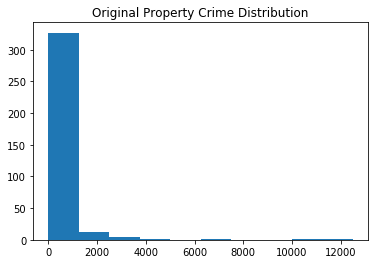

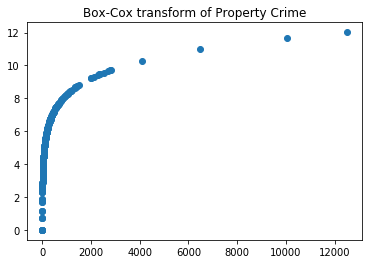

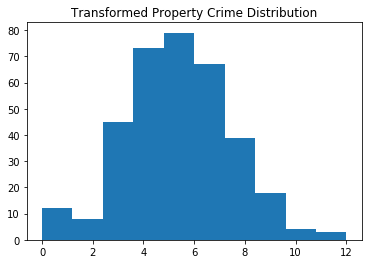

In [96]:
#Let's try a box-cox transform on our target variable (due to high skewness)

#6 cities have 0 property crime - can't use zeros in box-cox transform
#Try adding a value of 1 to every city 
df_final['Property Crime V2'] = df_final['Property Crime'].apply(lambda x: x+1)

#133 cities have 0 robberies (so the log transform results in a value of -inf, which is not usable.)
#Try adding a value of 1 to every city  

df_final['Robbery V2'] = df_final['Robbery'] + 1
df_final['Robbery_log'] = np.log(df_final['Robbery V2'])

#Some cities have 0 murders (so the log transform results in a value of -inf, which is not usable.)
#Try adding a value of 1 to every city  
df_final['Murder V2'] = df_final['Murder'] + 1
df_final['Murder_log'] = np.log(df_final['Murder V2'])

#Some cities have 0 violent crimes (so the log transform results in a value of -inf, which is not usable.)
#Try adding a value of 1 to every city  
df_final['Violent_Crime_PP V2'] = (df['Violent\ncrime'] + 1)/df['Population']
df_final['VCPP_log'] = np.log(df_final['Violent_Crime_PP V2'])

df_final['Population_log'] = np.log(df_final['Population'])


plt.hist(df_final['Property Crime V2']) 
plt.title('Original Property Crime Distribution')
plt.show()


from scipy.stats import boxcox

bc = boxcox(df_final['Property Crime V2'])

plt.scatter(df_final['Property Crime V2'], bc[0])
plt.title('Box-Cox transform of Property Crime')
plt.show()

df_final['Property Crime BC Transform'] = bc[0]


plt.hist(df_final['Property Crime BC Transform']) 
plt.title('Transformed Property Crime Distribution')
plt.show()

Some of our predictors are absolute volumes, others are per capita. This is fine for our example model here, but in reality we should rigorously test all variations and probably should maintain consistency between per capita or absolute numbers.

Let's see which (if any) of our predictors vary linearly with our transformed target variable. This is the first assumption of linear regression.

In [97]:
df_final.head()

,City,Population,Population_Sq,Murder_Binary,Robbery_Binary,Robbery,Murder,Violent_Crime_PP,Property Crime,Property Crime V2,Robbery V2,Robbery_log,Murder V2,Murder_log,Violent_Crime_PP V2,VCPP_log,Population_log,Property Crime BC Transform
0,Adams Village,1861.0,3.463321e+06,0,0,0.0,0.0,0.000000,12.0,13.0,1.0,0.000000,1.0,0.000000,0.000537,-7.528869,7.528869,2.733778
1,Addison Town and Village,2577.0,6.640929e+06,0,0,0.0,0.0,0.001164,24.0,25.0,1.0,0.000000,1.0,0.000000,0.001552,-6.468087,7.854381,3.487699
2,Akron Village,2846.0,8.099716e+06,0,0,0.0,0.0,0.001054,16.0,17.0,1.0,0.000000,1.0,0.000000,0.001405,-6.567375,7.953670,3.040133
3,Albany,97956.0,9.595378e+09,1,1,227.0,8.0,0.008075,4090.0,4091.0,228.0,5.429346,9.0,2.197225,0.008085,-4.817712,11.492274,10.275356
4,Albion Village,6388.0,4.080654e+07,0,1,4.0,0.0,0.003601,223.0,224.0,5.0,1.609438,1.0,0.000000,0.003757,-5.584123,8.762177,6.200308


Even though there is no chance binary variables for Murder and Robbery will be more useful than the raw or per capita values, it is still good practice to transform the binary/categorical variables into model features to see if they can increase our predictive power.

In [98]:
binaries = pd.get_dummies(df_final[['Murder_Binary','Robbery_Binary']], columns=['Murder_Binary','Robbery_Binary'])

In [99]:
df_final = pd.concat([df_final, binaries], axis=1, sort = False)
df_final.drop(['Murder_Binary','Robbery_Binary'], axis=1, inplace=True)

In [100]:
df_final.head()

,City,Population,Population_Sq,Robbery,Murder,Violent_Crime_PP,Property Crime,Property Crime V2,Robbery V2,Robbery_log,Murder V2,Murder_log,Violent_Crime_PP V2,VCPP_log,Population_log,Property Crime BC Transform,Murder_Binary_0,Murder_Binary_1,Robbery_Binary_0,Robbery_Binary_1
0,Adams Village,1861.0,3.463321e+06,0.0,0.0,0.000000,12.0,13.0,1.0,0.000000,1.0,0.000000,0.000537,-7.528869,7.528869,2.733778,1,0,1,0
1,Addison Town and Village,2577.0,6.640929e+06,0.0,0.0,0.001164,24.0,25.0,1.0,0.000000,1.0,0.000000,0.001552,-6.468087,7.854381,3.487699,1,0,1,0
2,Akron Village,2846.0,8.099716e+06,0.0,0.0,0.001054,16.0,17.0,1.0,0.000000,1.0,0.000000,0.001405,-6.567375,7.953670,3.040133,1,0,1,0
3,Albany,97956.0,9.595378e+09,227.0,8.0,0.008075,4090.0,4091.0,228.0,5.429346,9.0,2.197225,0.008085,-4.817712,11.492274,10.275356,0,1,0,1
4,Albion Village,6388.0,4.080654e+07,4.0,0.0,0.003601,223.0,224.0,5.0,1.609438,1.0,0.000000,0.003757,-5.584123,8.762177,6.200308,1,0,0,1


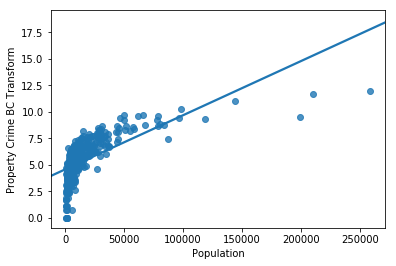

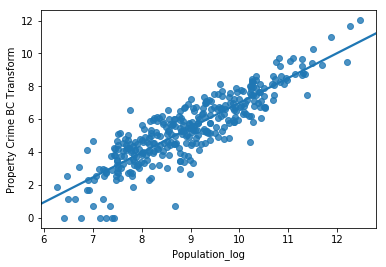

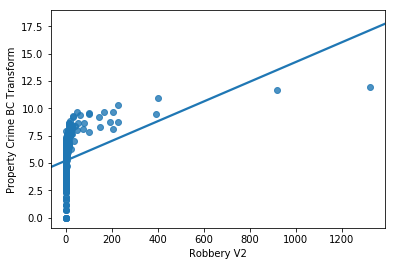

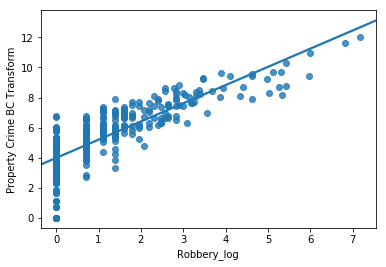

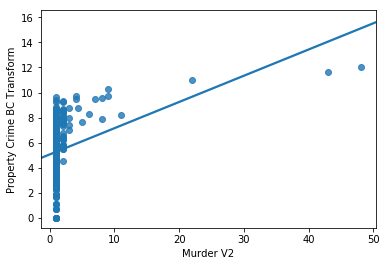

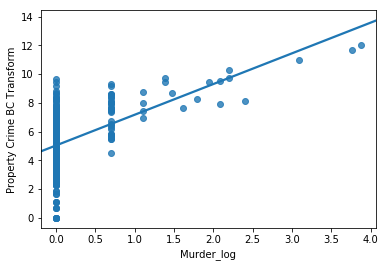

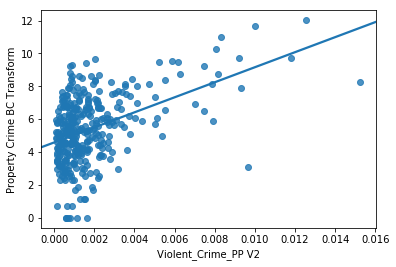

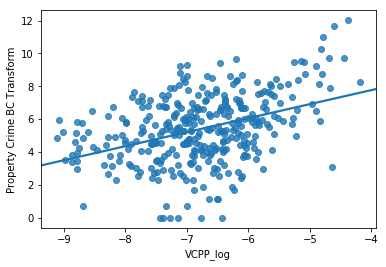

In [102]:
#Test linearity between predictors and outcome

sns.regplot(df_final['Population'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

sns.regplot(df_final['Population_log'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

sns.regplot(df_final['Robbery V2'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

sns.regplot(df_final['Robbery_log'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

sns.regplot(df_final['Murder V2'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

sns.regplot(df_final['Murder_log'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

sns.regplot(df_final['Violent_Crime_PP V2'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

sns.regplot(df_final['VCPP_log'], df_final['Property Crime BC Transform'], ci = False)
plt.show()

Population log and robbery log look to be pretty good predictors of the transformed dependent variable... let's try the model with these two (and maybe murder_log and violent crimes per person log).

In [103]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

X = df_final[['Population_log', 'Robbery_log', 'Murder_log', 'VCPP_log']]
Y = df_final['Property Crime BC Transform']

regr.fit(X,Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 1.44685318  0.08505931 -0.32965352  0.65143846]

Intercept: 
 -3.1683154074817494

R-squared:
0.8508216054838763


Let's take a look at how the model did, visually:

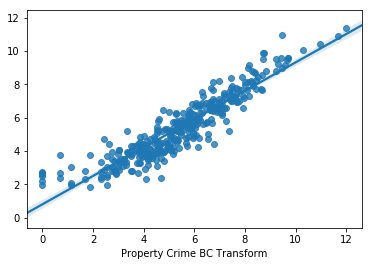

In [104]:
predicted = regr.predict(X).ravel()
actual = df_final['Property Crime BC Transform']

residual = actual - predicted

sns.regplot(actual, predicted)
plt.show()

Looks pretty good overall. Slight overpredictions at the low end of the transformed property crime values. Let's take a look at the distribution of residuals, and their skedasticity.


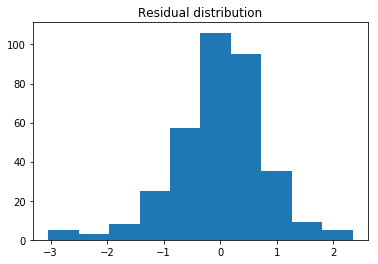

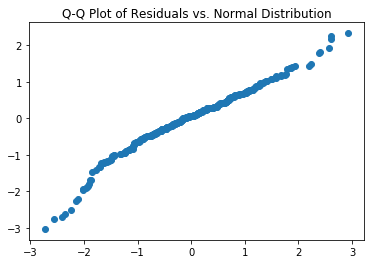

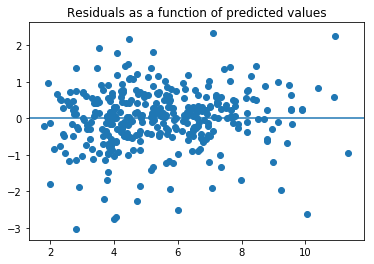

In [109]:
plt.hist(residual)
plt.title('Residual distribution')
plt.show()

norm = np.random.normal(0,1,len(residual))
norm = np.sort(norm)
residual = np.sort(residual)
plt.scatter(norm, residual)
plt.title('Q-Q Plot of Residuals vs. Normal Distribution')
plt.show()


plt.scatter(predicted, residual)
plt.axhline(y=0)
plt.title('Residuals as a function of predicted values')
plt.show()

The assumptions of the linear model held pretty well. Our residuals look mostly normal, and we do not see heteroskedasticity - the residuals are mostly randomly spread across the various range of predicted values.

Now let's see how the R^2 holds up with cross-validation.

In [112]:
from sklearn.model_selection import cross_validate

regr=linear_model.LinearRegression()

cross_validate(regr, X, Y, cv=3, return_train_score=True)

{'fit_time': array([0.00166202, 0.00141597, 0.00187516]),
 'score_time': array([0.00032806, 0.00033402, 0.0003767 ]),
 'test_score': array([0.85793362, 0.8199823 , 0.84820033]),
 'train_score': array([0.84333122, 0.86294557, 0.84985259])}

Our model is robust - it explains 82-86% of the variance in our cross-validation test. We're done! Just for fun, let's check the collinearity - ideally we should have a low correlation between our predictors.

                Population_log  Robbery_log  Murder_log  VCPP_log
Population_log        1.000000     0.787565    0.513633  0.115048
Robbery_log           0.787565     1.000000    0.702067  0.552247
Murder_log            0.513633     0.702067    1.000000  0.440873
VCPP_log              0.115048     0.552247    0.440873  1.000000


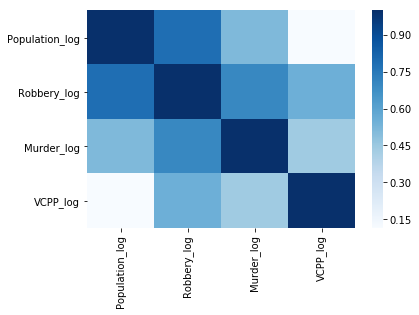

In [114]:
corr = X.corr()
print(corr)
sns.heatmap(corr, cmap = 'Blues')
plt.show()

Perhaps not surprisingly, there is a lot of correlation between these variables - particularly Robbery & Murder. We could use PCA to reduce the feature set and get rid of some of this collinearity, BUT we are only interested in predictions, not necessarily the explanatory power of the variables themselves. 

From the Thinkful lesson on linear regression assumptions:

# Assumption four: low multicollinearity
Correlations among features should be low or nonexistent. When features are correlated, they may both explain the same pattern of variance in the outcome. The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other. This isn’t a problem if our only goal is prediction, because then all that matters is that the variance gets explained. However, if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

Multicollinearity can be fixed by PCA or by discarding some of the correlated features.